Visualization code is based on the following post: 
http://tiao.io/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/

In [817]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

#from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from functools import partial

import math
import random

## The loss function

In [818]:
def f(x, y):
    return (x*y-1)**2
    #return ((x-0.5)*(y-1)-1)**2

## Grid intialization

In [819]:
xmin, xmax, xstep = -5, 5, .2
ymin, ymax, ystep = -5, 5, .2
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x, y)

### 3D Surface Plot

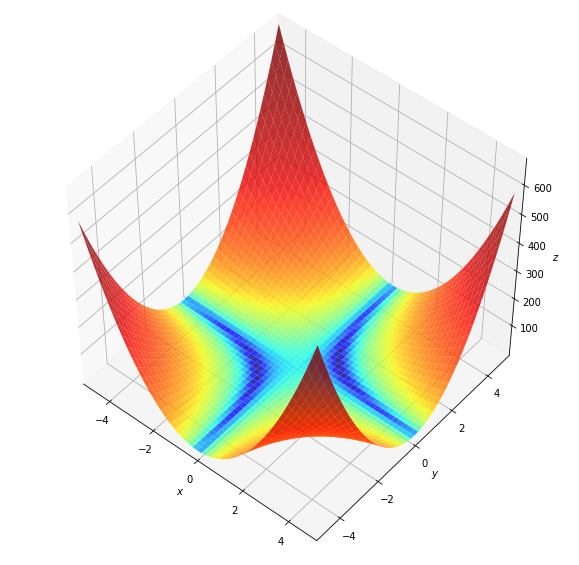

In [820]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

### 2D Contour Plot and Gradient Vector Field

In [951]:
def grad(x,y,grad_noise=0.):
    if grad_noise==0.:
        dx = 2*y*(x*y-1)
        dy = 2*x*(x*y-1)
    else:
        c=np.random.normal(loc=1.0, scale=grad_noise) 
        dx = 2*y*(x*y-c) 
        dy = 2*x*(x*y-c)    
        dx += grad_noise *  random.uniform(-1, 1) # min(1,abs(dx)) *
        dy += grad_noise *  random.uniform(-1, 1) # min(1,abs(dy)) 
    return (dx,dy)

dz_dx, dz_dy=grad(x,y)

We can also use [autograd](https://github.com/HIPS/autograd) to compute the gradient vector field, and plot it with Matplotlib's [quiver](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.quiver) method.

In [952]:
#dz_dx = elementwise_grad(f, argnum=0)(x, y)
#dz_dy = elementwise_grad(f, argnum=1)(x, y)

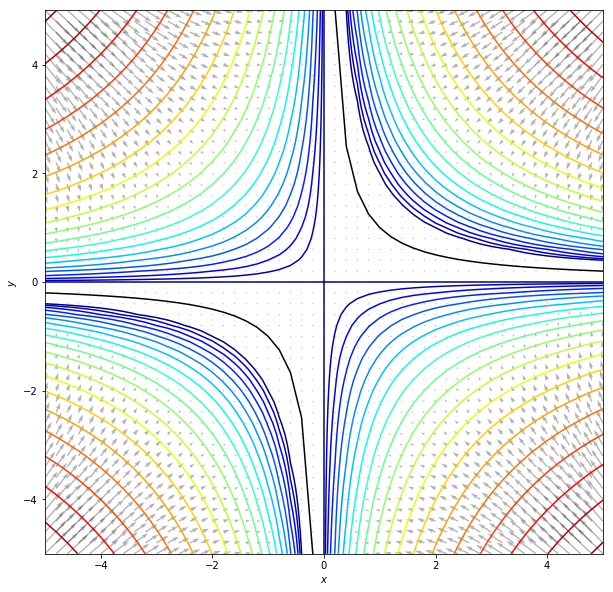

In [953]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(x, y, x - dz_dx, y - dz_dy, alpha=0.3)
ax.plot(np.arange(xmin, 0, xstep), 1./np.arange(xmin, 0, xstep), '-k')
ax.plot(np.arange(xstep, xmax + xstep, xstep), 1./np.arange(xstep, xmax + xstep, xstep), '-k')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [954]:
def init_weights(init_range):
    x_t= random.uniform(-init_range, init_range)
    y_t= random.uniform(-init_range, init_range)
    return (x_t, y_t)

def learning_rate(lr0, lr_min, lr_policy, t, xt, yt, rampup=0):
    lr=lr0
    if (lr_policy == 'decay'):
        lr = lr0 / math.sqrt(1. + t)
    elif (lr_policy == 'opt'):
        n=xt*xt + yt*yt
        d=(xt*yt - 1) * xt*yt
        eps= 0.000001
        if abs(d) < eps :
             d=sign(d)*eps
             lr = 0.25
        else:
            if n*n > 8*d:
                lr=(n - math.sqrt(n*n - 8*d))/(8*d)
            else:
                lr=n/(8*d)
    
    lr = lr0*max(abs(lr), lr_min)
    
    if (rampup > 0) and (t < rampup):
        lr = min(lr, lr0  * (t / rampup))
    
    return lr

def plot_loss(p):
    loss = p[:,2]
    larc_mode=p[:,3] / 3
    T = loss.size
    max_loss = np.nanmax(loss)
    t = np.arange(0, T, 1)
    # Now we are using the Qt4Agg backend open an interactive plot window
    plt.figure(figsize=(10,6))
    #plt.plot(t, loss)
    plt.scatter(t,loss,c=larc_mode)
    plt.axis([0., T+1, 0., max_loss+0.1])
    plt.grid(True)
    plt.ylabel('Loss')
    plt.xlabel('Iteration')

# Define training parameters

In [1268]:
Dataset = 100.

Batch   = 20.

grad_noise = 1.0 - math.sqrt(Batch/Dataset) 
#grad_noise = 0. #1.0 #5

N=int(1000/Batch)
lr0 = 0.2 *  math.sqrt(Batch)  #0.1
lr_policy = 'decay'#'opt'
lr_min=0.00001

rampup = 0
larc = True #False # 
eta  = 2.0
larc_minlr=0.1 #.1

momentum = 0.9  #9 #

adam_beta2= 0.99 #95
adam_eps =  0.001 

wd=0.0005 #0.001

init_range= 0.1

## Start Training

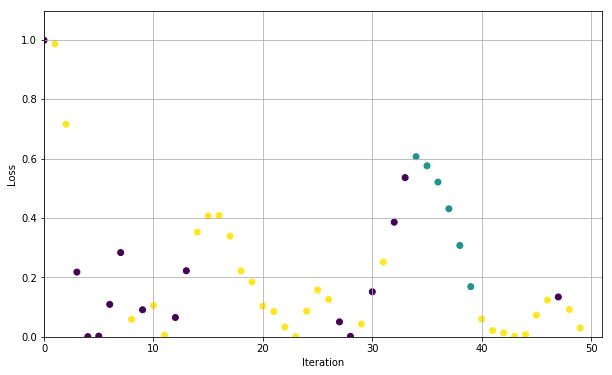

In [1269]:
p=np.zeros((N,4), dtype=float)
xt,yt = init_weights(init_range) 
#xt, yt = -0.005, -0.02

p[0,:]=[xt, yt, f(xt,yt),0]
m_x, m_y=0,0
v_x, v_y=0,0
for t in range(0, N-1):
    lr=learning_rate(lr0, lr_min, lr_policy, t, xt, yt, rampup)

    dx,dy= grad(xt,yt,grad_noise)
#     if grad_noise > 0.0 :
#         dx += grad_noise * abs(dx) * random.uniform(-1, 1)
#         dy += grad_noise * abs(dy) * random.uniform(-1, 1)

    #print (dx,dy)

    larc_mode=0
    if larc:
        #if (abs(xt) > larc_epsilon):
        #if (abs(dx) > larc_epsilon):
        if abs(dx) > abs(xt)*eta:
                local_lr= abs(xt)* eta / abs(dx)
                if local_lr < larc_minlr:
                    local_lr=larc_minlr
                    larc_mode = max(larc_mode, 1)
                else:
                    larc_mode = 2
                #print(t, " xt=", xt, " l_x=", local_lr)
                dx = dx * local_lr
        #if (abs(yt) > larc_epsilon):
        #if (abs(dy) > larc_epsilon):
        if abs(dy) > abs(yt)*eta :
                local_lr= abs(yt) * eta / abs(dy)
                if local_lr < larc_minlr:
                    local_lr=larc_minlr
                    larc_mode = max(larc_mode, 1)
                else:
                    larc_mode = 2
                #print (t, " yt=", yt, " l_y=", local_lr)
                dy = dy * local_lr   

    if wd > 0.0 :
        dx += wd*xt
        dy += wd*yt
                        
    if (momentum>0):
        m_x = momentum*m_x + (1-momentum)*dx
        m_y = momentum*m_y + (1-momentum)*dy
        if (adam_beta2>0):   
            v_x = max(v_x, adam_beta2*v_x + (1-adam_beta2)*dx*dx)
            v_y = max(v_y, adam_beta2*v_y + (1-adam_beta2)*dy*dy)
            dx = m_x / math.sqrt(v_x+adam_eps)
            dy = m_y / math.sqrt(v_y+adam_eps)
        else:
            dx, dy = m_x, m_y
            

    
    #print (dx,dy)
    xt = xt - lr*dx
    yt = yt - lr*dy
    p[t+1,:] = [xt, yt, f(xt,yt), larc_mode]

# print( p )
plot_loss(p)

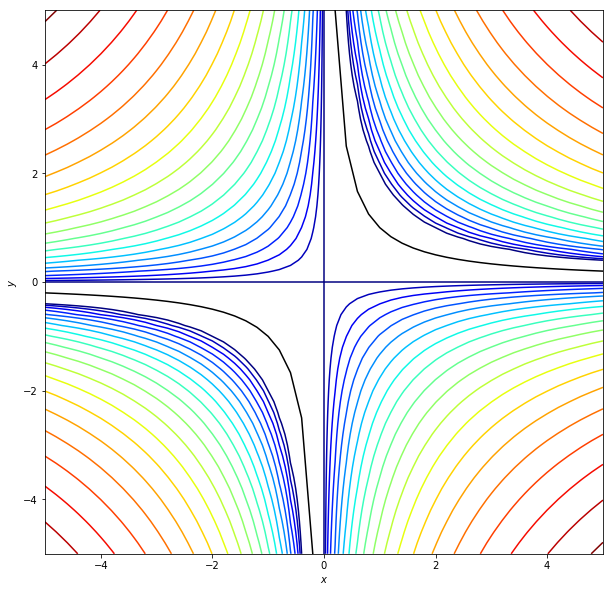

In [1270]:
fig, ax = plt.subplots(figsize=(10, 10))

path = p[:,:2].T

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(np.arange(xmin, 0, xstep), 1./ np.arange(xmin, 0, xstep), '-k')
ax.plot(np.arange(xstep, xmax + xstep, xstep), 1./np.arange(xstep, xmax + xstep, xstep), '-k')

line, = ax.plot([], [], 'b')
point, = ax.plot([], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))


def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def animate(i):
    line.set_data(*path[::,:i])
    point.set_data(*path[::,i-1:i])
    return line, point

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)


In [1271]:
HTML(anim.to_html5_video())